# First DataSet: MovieLens
(https://grouplens.org/datasets/movielens)

## Problem Statement

Nowadays, we need recommender systems almost everywhere in our lives. Therefore, retailers are become more interested in recommender systems to analyze patterns of user interest in products and provide personalized recommendations. The first goal of this project is understanding, analyzing, and correlating the trend in average rating movies of different genres from 1995-2015. The second goal is building a recommender engine to predict the rating of each movie. 

## Business Objective

The recommender system is useful to any business that makes money via recommendations. Since we want to work with movie dataset, the client of this project could be Amazon, Netflix, Hulu, HBO, etc. 
Giving good recommendations will help users spend less time searching for their type of movie and having a recommender platform. This will help the customer to continue with the service and having a good experience.

## Data

Two data set have been used for this project:

1- The first data set has been collected from a free, noncommercial movie recommender MoviLens.org. (https://grouplens.org/datasets/movielens) This recommender is like Netflix, minus the ability to watch movies. The dataset which was released in April 2015 contains 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users (movies.csv, ratings.csv, link.csv). The data has been created in October 2016. Users were selected at random for inclusion. All selected users had rated at least 20 movies. 

2- The second data set is from https://www.kaggle.com/karrrimba/movie-metadatacsv 

## Solution

- **How to get the insight about how people’s rating change for different genres over the years?**

Getting different distributions of the movie-ratings and  movie-relevancy across title, genre, year, and tag of each movie can give the insight about how people’s taste vary over the years. Different inferential statistics and visualization techniques can be implemented to deliver a better understanding of the trends.
 
- **How to predict the rating?**

In this work several recommender engines like Content-base filtering, Collaborative filtering (CF), and hybrid techniques will use to analyze relationships between users and interdependencies among products to identify new user-item associations. The best solution will be the CF algorithms which are based on a user-item rating matrix where each row represents a user, each column an item. The entries of this matrix are ratings given by users to items. ne of the primary areas of collaborative filtering is the latent factor models which are based on matrix factorization. In this work, the Singular Value Decomposition (SVD) technique will be used to predict the ratings. 


## Import libraries, Read the data

In [53]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate, SlopeOne, NMF, SVDpp, KNNBaseline, CoClustering, accuracy
from surprise.model_selection import cross_validate
from __future__ import (absolute_import, division, print_function,unicode_literals)
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit
import tensorrec

Reading the data

In [2]:
r=pd.read_csv('ratings.csv')
r.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
movies=pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Data Wrangling

In [4]:
movies['genres'] = movies['genres'].str.split('|')
movies['year']=movies['title'].str[-5:-1]
movies=movies[(movies['title'].str[-1]==')')&(movies['title'].str[-6]=='(')] #drop the movies without year in title
movies.year=pd.to_numeric(movies.year)
movies['Decade']=movies['year']//10 *10
movies=movies.set_index('movieId')
movies.sort_values('year').head() 

,title,genres,year,Decade
movieId,,,,
129851,Dickson Greeting (1891),[(no genres listed)],1891,1890
95541,Blacksmith Scene (1893),[(no genres listed)],1893,1890
94951,Dickson Experimental Sound Film (1894),[Musical],1894,1890
88674,Edison Kinetoscopic Record of a Sneeze (1894),[Documentary],1894,1890
120869,Employees Leaving the Lumière Factory (1895),[Documentary],1895,1890


** Seperating each Genre**

In [5]:
sep = movies.reset_index().set_index(['movieId','title','year'])['genres'].apply(pd.Series).stack()
sep = sep.reset_index()
sep.columns=['movieId','title','year','level','genres']
sep.to_csv('sep.csv')
print('Available Genres: ',sep.genres.unique())
sep.head()

Available Genres:  ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


,movieId,title,year,level,genres
0,1,Toy Story (1995),1995,0,Adventure
1,1,Toy Story (1995),1995,1,Animation
2,1,Toy Story (1995),1995,2,Children
3,1,Toy Story (1995),1995,3,Comedy
4,1,Toy Story (1995),1995,4,Fantasy


# Exploratory Data Analysis (Story telling)

Total number of movies of each Genre

**Drama, Comedy, and Thriller** have the most production.


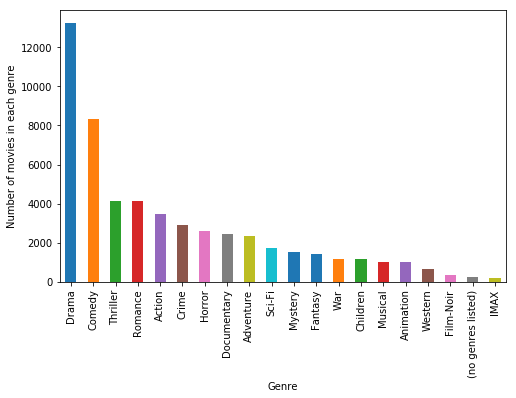

In [6]:
plt.figure(figsize=(8,5))
sep['genres'].value_counts().plot(kind='bar')
plt.ylabel('Number of movies in each genre')
plt.xlabel('Genre')
plt.show()

Total number of movies in each decade

Most production was in **2000 decade.**

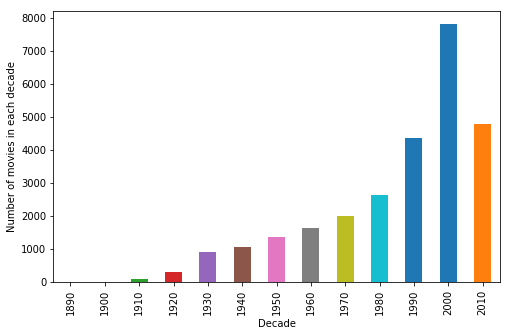

In [7]:
plt.figure(figsize=(8,5))
movies['Decade'].value_counts().sort_index().plot(kind='bar') 
plt.xlabel('Decade')
plt.ylabel('Number of movies in each decade')
plt.show()

3 years with most Drama genre are:

Most drama movies produced in **2009, 2007, and 2008** respectively.

In [8]:
sep[sep['genres']=='Drama']['year'].value_counts().head(3) 

2009    505
2007    473
2008    462
Name: year, dtype: int64

Number of drama movies in each decade.

Most drama movies produced in **2000 decade**.

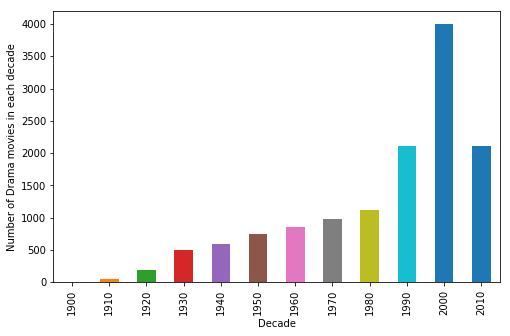

In [9]:
plt.figure(figsize=(8,5))
sep['Decade']=sep['year']//10 *10
sep[sep['genres']=='Drama']['Decade'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Decade')
plt.ylabel('Number of Drama movies in each decade')
plt.show()

Movies with same title including the year are:

*16 movies* are with same title.

In [10]:
sum(movies['title'].value_counts()>1)

16

These movies which have repeated twice including the year are:

In [11]:
movies['title'].value_counts().head(16) 

Johnny Express (2014)                  2
Casanova (2005)                        2
Paradise (2013)                        2
Girl, The (2012)                       2
Clear History (2013)                   2
Aladdin (1992)                         2
20,000 Leagues Under the Sea (1997)    2
Blackout (2007)                        2
Men with Guns (1997)                   2
Chaos (2005)                           2
Darling (2007)                         2
Beneath (2013)                         2
Emma (1996)                            2
Offside (2006)                         2
War of the Worlds (2005)               2
Hamlet (2000)                          2
Name: title, dtype: int64

These movie titles (excluding the year in the title) have been repeated several times.

In [12]:
movies['Name']=movies['title'].str[:-7] #removing the year from title
movies['Name'].value_counts().head(20) 

Misérables, Les                   9
Hamlet                            8
Three Musketeers, The             7
Wuthering Heights                 6
Alice in Wonderland               6
Christmas Carol, A                6
Cinderella                        5
Jane Eyre                         5
Cargo                             4
Carrie                            4
20,000 Leagues Under the Sea      4
Hound of the Baskervilles, The    4
Angel                             4
The Count of Monte Cristo         4
Dangerous Liaisons                4
Dr. Jekyll and Mr. Hyde           4
Boy Meets Girl                    4
Paradise                          4
Emma                              4
Treasure Island                   4
Name: Name, dtype: int64

8 movies have been produced with the title 'Hamlet', The following barplot shows the number of 'Hamlet' movies in each decade.

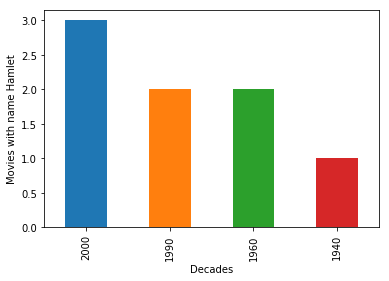

In [13]:
movies[movies.Name=='Hamlet'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Hamlet')
plt.show()


9 movies has been produced with title 'Misérables, Les'. The following barplot shows the number of 'Misérables, Les' movies in each decade. 

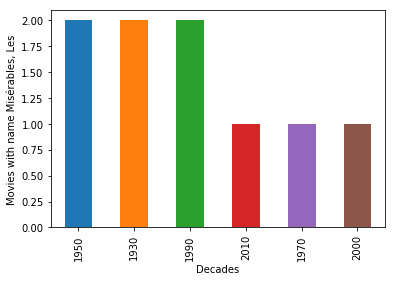

In [14]:
movies[movies.Name=='Misérables, Les'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Misérables, Les')
plt.show()

In [15]:
r.rating.value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

Movies with highest rankings are:

**Rank=5**
- As it was expected, **Shawshank Redemption, Pulp Fiction and Silence of the Lambs** are the first three.

**Rank=4.5**
- The first three are, **Shawshank Redemption, Matrix, and Pulp Fiction.**

**Rank=4**
- The first three are, **Silence of the Lambs, Fugitive, and Jurassic.**


In [16]:
List=[]
for i in np.arange(4,5.5, 0.5):
    M=movies.loc[r[r.rating==i].movieId.value_counts().head(10).index,'title']
    print('Rate: %f' %i)
    print(M)
    print(' ')

Rate: 4.000000
593             Silence of the Lambs, The (1991)
457                         Fugitive, The (1993)
356                          Forrest Gump (1994)
480                         Jurassic Park (1993)
589            Terminator 2: Judgment Day (1991)
150                             Apollo 13 (1995)
1                               Toy Story (1995)
296                          Pulp Fiction (1994)
32     Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
110                            Braveheart (1995)
Name: title, dtype: object
 
Rate: 4.500000
318                      Shawshank Redemption, The (1994)
2571                                   Matrix, The (1999)
296                                   Pulp Fiction (1994)
2959                                    Fight Club (1999)
4993    Lord of the Rings: The Fellowship of the Ring,...
5952        Lord of the Rings: The Two Towers, The (2002)
7153    Lord of the Rings: The Return of the King, The...
50                             Usual Suspects

Average rating for the **Shawshank Redemption** is:

In [17]:
r[r.movieId==318].rating.mean()  #Average rating for the 'Shawshank Redemption, The'

4.446990499637029

Average rating for the **Pulp Fiction** is:

In [18]:
r[r.movieId==296].rating.mean() #Average rating for 'Pulp Fiction' 

4.174231169217055

The movies with the max number of ratings are:

**Pulp Fiction, Forrest Gump, Shawshank redemption** respectively.

In [19]:
MaxRating=r['movieId'].value_counts().head(10)

In [20]:
movies.loc[MaxRating.index,'title'] 

296                           Pulp Fiction (1994)
356                           Forrest Gump (1994)
318              Shawshank Redemption, The (1994)
593              Silence of the Lambs, The (1991)
480                          Jurassic Park (1993)
260     Star Wars: Episode IV - A New Hope (1977)
110                             Braveheart (1995)
589             Terminator 2: Judgment Day (1991)
2571                           Matrix, The (1999)
527                       Schindler's List (1993)
Name: title, dtype: object

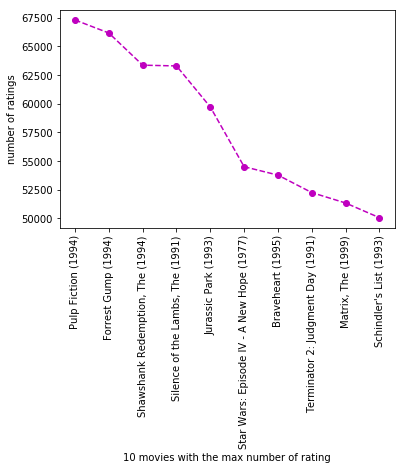

In [21]:
plt.plot(range(len(MaxRating)), MaxRating,'mo--')
plt.xticks(range(len(MaxRating)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('10 movies with the max number of rating')
plt.ylabel('number of ratings')
plt.show()

The movies with the highest average rating are:

**Pulp Fiction, Forrest Gump, Shawshank redemption** respectively

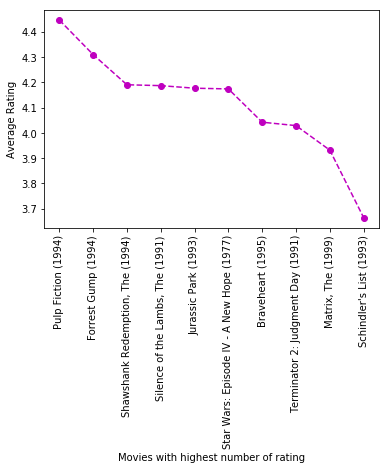

In [22]:
List5=[]
for i in MaxRating.index:
    List5.append(r[r.movieId==i].rating.mean())
plt.plot(range(len(List5)), sorted(List5,reverse=True),'mo--')
plt.xticks(range(len(List5)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('Movies with highest number of rating')
plt.ylabel('Average Rating')
plt.show()

In [23]:
MinRating=r['movieId'].value_counts()
MinRating=MinRating[MinRating==1]
print('Number of movies which are rated once:',movies.loc[MinRating.index,'title'].shape) 

Number of movies which are rated once: (3972,)


C:\Python\Anaconda3\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Merge movie and rating data frames.

In [24]:
r1= r.merge(sep.reset_index(), left_on='movieId', right_on='movieId', how='inner')
del r1['timestamp']
r1.head() #merge sep and rating

,userId,movieId,rating,index,title,year,level,genres,Decade
0,1,2,3.5,5,Jumanji (1995),1995,0,Adventure,1990
1,1,2,3.5,6,Jumanji (1995),1995,1,Children,1990
2,1,2,3.5,7,Jumanji (1995),1995,2,Fantasy,1990
3,5,2,3.0,5,Jumanji (1995),1995,0,Adventure,1990
4,5,2,3.0,6,Jumanji (1995),1995,1,Children,1990


Boxplot of 'Decade' vs 'Rating'

*Movies of **40th decade** has the highest rating*

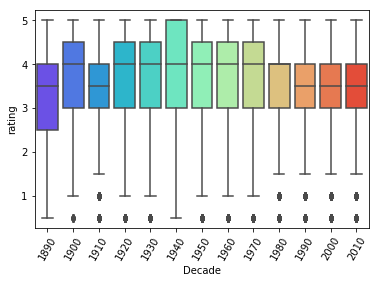

In [25]:
sns.boxplot(x='Decade', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=60)
plt.show()

Boxplot of the 'Decade' vs 'Genres'

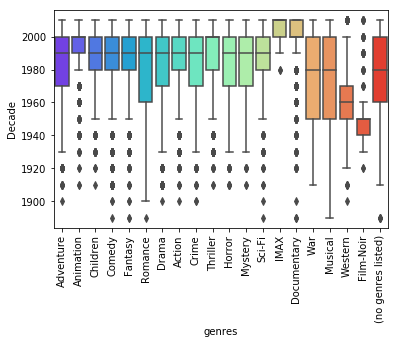

In [26]:
sns.boxplot(x='genres', y='Decade', data=sep,palette='rainbow')
plt.xticks(rotation=90)
plt.show()

Average rating of the ppl with highest number of rating

In [27]:
ID=r1.userId.value_counts().head(10) #UserID wih highest number of rating
List5=[]
for i in ID.index:
    List5.append(r1[r1.userId==i]['rating'].mean())

List5

[3.2909304463282605,
 3.2126359112967626,
 1.654984847307483,
 3.026239975083703,
 2.780034504391468,
 3.765411234508289,
 3.4983650780675224,
 3.225420576549159,
 2.4983633387888706,
 3.3196820944366525]

Boxplot of the 'Genre' vs 'Rating' 

**Drama, Mystery,Crime, War,Imax, documentary** has the highest ratings. **Horror** is the least favorit.

<function matplotlib.pyplot.show(*args, **kw)>

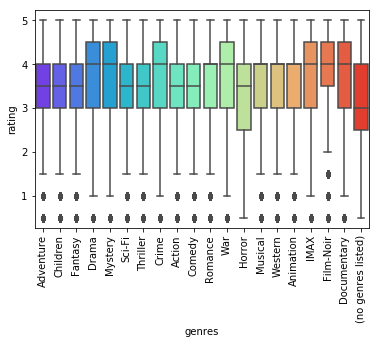

In [28]:
sns.boxplot(x='genres', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=90)
plt.show

Correlation matrix: (There is no correlation)

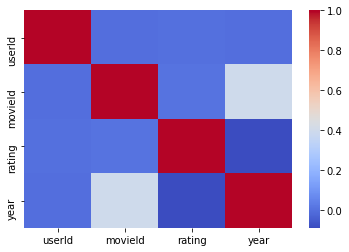

In [29]:
sns.heatmap(r1[['userId','movieId','rating','year']].corr(),cmap='coolwarm')
plt.show()

 ## Title and Overview Wordclouds
There are certain words that use more often in titles. I use WordCloud library to find out what are these words.

The word **Love** is the most commonly used word in movie titles. **Girl**, **Day** and **Man** are also among the most commonly occuring words. 

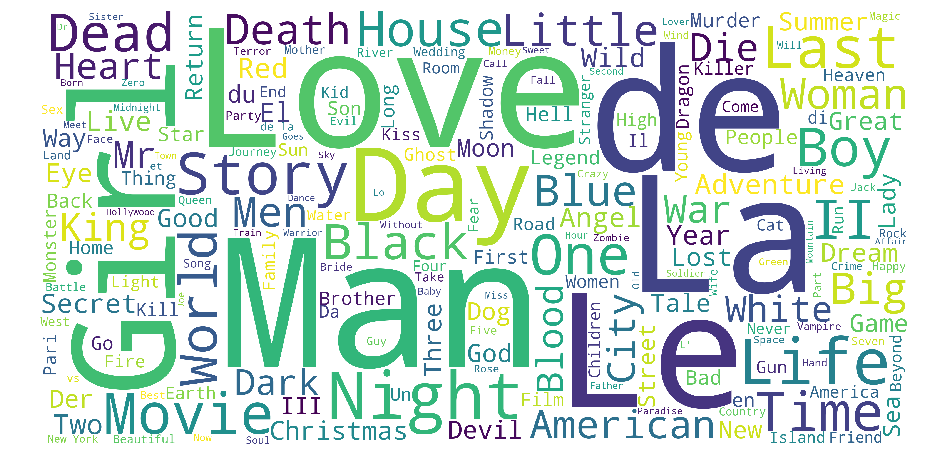

In [30]:
movies['title'] = movies['title'].astype('str')

title_corpus = ' '.join(movies['title'])


title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

# Recommender System


### Preparing the data

In [31]:
movielens=r.drop(['timestamp'],axis=1)
movielens=movielens.iloc[(r.userId.value_counts()>100).index,:]#user id with more than 100 voting

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(movielens[['userId','movieId']],movielens['rating'],test_size=0.25, 
                                                  random_state=55)

y_train=pd.DataFrame(y_train)
train=X_train.join(y_train)

y_test=pd.DataFrame(y_test)
test=X_test.join(y_test)

## Well-known Solutions to the Recommendation Problem are:


## 1- Simple Recommender
The Simple Recommender offers generalized recommnendations to every user based on movie popularity, ratings, and genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user. 

So I sort the movies base on their genre, and I recommend the ones with the highest number of votes and the higher average rankings to the new audience.

In [33]:
r1=r1[['userId','movieId','rating','title','genres']]
r1.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure
1,1,2,3.5,Jumanji (1995),Children
2,1,2,3.5,Jumanji (1995),Fantasy
3,5,2,3.0,Jumanji (1995),Adventure
4,5,2,3.0,Jumanji (1995),Children


### The list of the 10 best Drama movies to recommend are:


In [34]:
a=r1[r1.genres=='Drama'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>4.1)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Drama')&(r1.movieId==i)].title.iloc[0])

1 : Pulp Fiction (1994)
2 : Shawshank Redemption, The (1994)
3 : Schindler's List (1993)
4 : American Beauty (1999)
5 : Fargo (1996)
6 : Godfather, The (1972)
7 : Fight Club (1999)
8 : Lord of the Rings: The Return of the King, The (2003)
9 : One Flew Over the Cuckoo's Nest (1975)
10 : Godfather: Part II, The (1974)


### The list of the 10 best Romance movies to recommend are:


In [35]:
a=r1[r1.genres=='Romance'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>3.5)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Romance')&(r1.movieId==i)].title.iloc[0])

1 : Forrest Gump (1994)
2 : Beauty and the Beast (1991)
3 : Princess Bride, The (1987)
4 : Groundhog Day (1993)
5 : Shrek (2001)
6 : Sleepless in Seattle (1993)
7 : Good Will Hunting (1997)
8 : Four Weddings and a Funeral (1994)
9 : Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
10 : There's Something About Mary (1998)


### The list of the 10 best Action movies to recommend are:



In [36]:
a=r1[r1.genres=='Action'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>4)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Action')&(r1.movieId==i)].title.iloc[0])

1 : Star Wars: Episode IV - A New Hope (1977)
2 : Braveheart (1995)
3 : Matrix, The (1999)
4 : Star Wars: Episode VI - Return of the Jedi (1983)
5 : Star Wars: Episode V - The Empire Strikes Back (1980)
6 : Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
7 : Fight Club (1999)
8 : Saving Private Ryan (1998)
9 : Princess Bride, The (1987)
10 : Lord of the Rings: The Return of the King, The (2003)


## 2- Content-based filtering



The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 10 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

So in this secion I set an engine to recommend based on the user's rating history. Generic expression (notice how this is kind of a 'row-based' approach):

$$ 
\newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{i' \in I(u)} [r_{u,i'}]
$$


A simple example using the mean as an aggregation function:

$$ 
r_{u,i} = \bar r_u = \frac{\sum_{i' \in I(u)} r_{u,i'}}{|I(u)|} 
$$

In [37]:
def evaluate(estimate_f):
    ids_to_estimate = zip(test.userId, test.movieId)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = y_test.values
    return np.sqrt(np.mean(np.power(estimated-real, 2)))

def content_mean(user_id, movie_id):
    user_condition = X_train.userId == user_id
    return y_train[user_condition].mean()

start = time.time()
print('RMSE for content base filtering is: %s' % round(evaluate(content_mean),4))
end = time.time()
print('Total elapsed time of content base filtering is:',round(end - start,3))


RMSE for content base filtering is: 0.9969
Total elapsed time of content base filtering is: 61.474



## 3- Collaborative Filtering

Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.


#### 1- Simple Collaborative filtering base on mean

Recommend based on other user's rating histories. Generic expression (notice how this is kind of a 'col-based' approach):

$$ \newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{u' \in U(i)} [r_{u',i}] $$

A simple example using the mean as an aggregation function:

$$ r_{u,i} = \bar r_i = \frac{\sum_{u' \in U(i)} r_{u',i}}{|U(i)|}$$ 



In [38]:
def collab_mean(user_id, movie_id):
    user_condition = X_train.movieId == movie_id
    return y_train[user_condition].mean()
print(collab_mean(4653, 589))


rating    3.953441
dtype: float64


#### 2- Matrix Factorization-based algorithms

I use **Surprise** library which has several powerful algorithms like **Singular Value Decomposition (SVD), Non-negative Matrix Factorization (NMF), K Nearest Neighbor (KNN), and CoClusternig**  to minimise RMSE (Root Mean Square Error) and give recommendations.


In [39]:
data = Dataset.load_from_df(movielens[['userId', 'movieId', 'rating']], Reader())

In [40]:
Models=[SVD(), NMF(), SlopeOne(), KNNBaseline(), CoClustering()]

for i in Models:
    start = time.time()
    cross_validate(i, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    end = time.time()
    print('Total Elapsed time with model is:',end - start)
    print(' ')
    print(' ')

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9165  0.9119  0.9194  0.9091  0.9220  0.9158  0.0047  
MAE (testset)     0.7058  0.7010  0.7093  0.7029  0.7101  0.7058  0.0035  
Fit time          16.00   15.48   14.18   17.57   15.86   15.82   1.09    
Test time         0.25    0.25    0.25    0.23    0.36    0.27    0.05    
Total Elapsed time with model is: 81.90107011795044
 
 
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9560  0.9636  0.9502  0.9585  0.9592  0.9575  0.0044  
MAE (testset)     0.7364  0.7387  0.7284  0.7336  0.7390  0.7352  0.0039  
Fit time          15.98   15.27   15.72   12.91   13.61   14.70   1.22    
Test time         0.27    0.22    0.34    0.20    0.31    0.27    0.05    
Total Elapsed time with model is: 76.32422876358032
 
 
Evaluating RMSE, MAE of algori

From the results, **SVD** and **KNN** provide the lower RMSE for the test set.


Now lets compare the predicted rating values of some samples with their actual values:

In [41]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25, random_state=55)

Models=[SVD(), NMF(), SlopeOne(), KNNBaseline(), CoClustering()]
m=['SVD','NMF','Slop One','KNN Baseline', 'CoClustering']

count=0

for algo in Models:
    print(m[count])
    start = time.time()
    algo.fit(trainset)
    predictions = algo.test(testset)
    end = time.time()    
    print('Total Elapsed time with model is:',round(end - start,3))    
    print('Prediction of a particular user:', algo.predict(55, 260, 3))
    print('Prediction of a particular user:', algo.predict(55, 203, 3))
    print('Prediction of a particular user:', algo.predict(1,50, 3))
    print('')
    print('')
    count+=1


SVD
Total Elapsed time with model is: 16.452
Prediction of a particular user: user: 55         item: 260        r_ui = 3.00   est = 4.62   {'was_impossible': False}
Prediction of a particular user: user: 55         item: 203        r_ui = 3.00   est = 3.00   {'was_impossible': False}
Prediction of a particular user: user: 1          item: 50         r_ui = 3.00   est = 4.11   {'was_impossible': False}


NMF
Total Elapsed time with model is: 14.171
Prediction of a particular user: user: 55         item: 260        r_ui = 3.00   est = 4.56   {'was_impossible': False}
Prediction of a particular user: user: 55         item: 203        r_ui = 3.00   est = 2.66   {'was_impossible': False}
Prediction of a particular user: user: 1          item: 50         r_ui = 3.00   est = 4.17   {'was_impossible': False}


Slop One
Total Elapsed time with model is: 20.374
Prediction of a particular user: user: 55         item: 260        r_ui = 3.00   est = 4.49   {'was_impossible': False}
Prediction of a 

Actual rating of the samples:

In [42]:
print('Actual Rating of userId=55 and movieId=260 is:',movielens[(movielens.userId==55)&(movielens.movieId==260)].rating.values[0])
print('Actual Rating of userId=55 and movieId=203 is:',movielens[(movielens.userId==55)&(movielens.movieId==203)].rating.values[0])
print('Actual Rating of userId=1 and movieId=50 is:',movielens[(movielens.userId==1)&(movielens.movieId==50)].rating.values[0])

Actual Rating of userId=55 and movieId=260 is: 5.0
Actual Rating of userId=55 and movieId=203 is: 2.0
Actual Rating of userId=1 and movieId=50 is: 3.5


## 4- ALS Implicit Collaborative Filtering

In [46]:
data=movielens


sparse_item_user = sparse.csr_matrix((data['rating'].astype(float), (data['movieId'], data['userId'])))
sparse_user_item = sparse.csr_matrix((data['rating'].astype(float), (data['userId'], data['movieId'])))

# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

model.fit(data_conf)

100%|██████████| 20.0/20 [00:03<00:00,  7.19it/s]


#### Find similar items to 'Sahwshank Redemption'

In [48]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------
item_id = 318 #Shawshank Redemption
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.movieId.loc[data.movieId == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'MovieId': a, 'Score': b})

for i in a:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,318,0.310394,"Shawshank Redemption, The (1994)"
1,527,0.309371,Schindler's List (1993)
2,593,0.308900,"Silence of the Lambs, The (1991)"
3,296,0.308599,Pulp Fiction (1994)
4,50,0.308179,"Usual Suspects, The (1995)"
5,356,0.307320,Forrest Gump (1994)
6,110,0.307277,Braveheart (1995)
7,47,0.306583,Seven (a.k.a. Se7en) (1995)
8,480,0.305257,Jurassic Park (1993)
9,589,0.303026,Terminator 2: Judgment Day (1991)


### Find similar items to 'Pulp Fiction'

In [49]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------
item_id = 296 #Pulp fiction
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.movieId.loc[data.movieId == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'MovieId': a, 'Score': b})

for i in a:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,296,0.306645,Pulp Fiction (1994)
1,50,0.305682,"Usual Suspects, The (1995)"
2,593,0.305319,"Silence of the Lambs, The (1991)"
3,318,0.304871,"Shawshank Redemption, The (1994)"
4,527,0.304766,Schindler's List (1993)
5,47,0.304278,Seven (a.k.a. Se7en) (1995)
6,110,0.303050,Braveheart (1995)
7,356,0.302907,Forrest Gump (1994)
8,480,0.302016,Jurassic Park (1993)
9,589,0.300631,Terminator 2: Judgment Day (1991)


### Recommend movies to user_id=1

In [50]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 1
user_id =1

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

movies = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    movies.append(data.movieId.loc[data.movieId==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'MovieId': movies, 'Score': scores})

for i in movies:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,1274,1.341337,Akira (1988)
1,3703,1.298482,"Road Warrior, The (Mad Max 2) (1981)"
2,3508,1.277379,"Outlaw Josey Wales, The (1976)"
3,3681,1.274659,For a Few Dollars More (Per qualche dollaro in...
4,2105,1.272464,Tron (1982)
5,1748,1.266311,Dark City (1998)
6,2788,1.213520,Monty Python's And Now for Something Completel...
7,2951,1.205464,"Fistful of Dollars, A (Per un pugno di dollari..."
8,3702,1.189130,Mad Max (1979)
9,2657,1.173790,"Rocky Horror Picture Show, The (1975)"


### Recommend movies to user_id=903

In [51]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 903
user_id =903

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

movies = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    movies.append(data.movieId.loc[data.movieId==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'MovieId': movies, 'Score': scores})

for i in movies:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,2594,1.369689,Open Your Eyes (Abre los ojos) (1997)
1,1938,1.316449,"Lost Weekend, The (1945)"
2,2025,1.265688,Lolita (1997)
3,213,1.247192,Burnt by the Sun (Utomlyonnye solntsem) (1994)
4,2874,1.231940,"Pajama Game, The (1957)"
5,760,1.229541,Stalingrad (1993)
6,2940,1.226364,Gilda (1946)
7,5151,1.220052,40 Days and 40 Nights (2002)
8,2559,1.191427,"King and I, The (1999)"
9,2774,1.188486,Better Than Chocolate (1999)



# Need work, not finished
## 5- Deep Learning for Recommendation with Keras and TensorRec

Read this article for more info:
https://hackernoon.com/deep-learning-for-recommendation-with-keras-and-tensorrec-2b8935c795d0

In [ ]:
# Build the model with default parameters
model = tensorrec.TensorRec()

# Generate some dummy data
interactions, user_features, item_features = tensorrec.util.generate_dummy_data(
    num_users=100,
    num_items=150,
    interaction_density=.05
)

# Fit the model for 5 epochs
model.fit(interactions, user_features, item_features, epochs=5, verbose=True)

# Predict scores and ranks for all users and all items
predictions = model.predict(user_features=user_features,
                            item_features=item_features)
predicted_ranks = model.predict_rank(user_features=user_features,
                                     item_features=item_features)

# Calculate and print the recall at 10
r_at_k = tensorrec.eval.recall_at_k(predicted_ranks, interactions, k=10)
print(np.mean(r_at_k))
